In [1]:
from instrumentdatabaseapi import instrumentdatabaseapi as API
repo = API.Repository(local_repo=".")

In [2]:
print(repo)

URL: https://github.com/PaNOSC-ViNYL/instrument_database.git
local_dir: ./


Load the instrument configuration providing:
 - name of the institute
 - name of the instrument
 - version of the instrument description (HEAD is the most recent)
 - name of the simulation program

In [3]:
repo.ls_institutes()

 - EuXFEL
 - ILL
 - test_institute


In [4]:
repo.ls_instruments("ILL")

Available instruments for ILL:
 -  ILL/D22
 -  ILL/Panther
 -  ILL/ThALES
 -  ILL/IN5
 -  ILL/D11


In [5]:
instrument_name="Panther"
#instrument_name="ThALES"
#instrument_name="IN5"
#instrument_name="D11"

In [6]:
repo.ls_versions("ILL",instrument_name)

Available versions for instrument Panther:
 -  HEAD


In [7]:
repo.ls_simulation_programs("ILL",instrument_name,"HEAD")

Instrument Panther from institute ILL is implemented with the following programs:
 -  mcstas


In [8]:
repo.ls_flavours("ILL",instrument_name,"HEAD","mcstas")

Available flavours for instrument Panther:
 -  None
 -  nosection
 -  quick
 -  quicknosection


In [9]:
flavour="full"
flavour="nosection"
flavour="quicknosection"
myinstrument = repo.load("ILL", instrument_name, "HEAD", "mcstas", flavour, dep=False)

In [10]:
myinstrument.calculators

{'OriginCalc': <mcstasscript.interface.instr.McStas_instr at 0x7f225667bbe0>}

In [11]:
print(myinstrument)

######## Instrument Panther
- Instrument: Panther -
Calculators:
OriginCalc
- ParametersCollection object -
  Master Parameters
  energy                              0          [millielectron_volt]  Initial neutron energy   

   OriginCalc
    - Parameters object -
   mono_index                          -1                              Monochromator index. -1 = auto: based on the energy   (-1, 0, 1, 2, 3, 4)
   a2                                  0          [degree]             Angle between beam reflected by monochromator and incident beam   L[36.0 degree, 58.97 degree](0 degree)
   chopper_rpm                         0                               Fermi chopper speed   L[6000, 30000](0)
   chopper_ratio                       1                                  (1, 2)
   Ei                                  15         [millielectron_volt]  Initial neutron energy   L[7.5 millielectron_volt, 130 millielectron_volt]
   dE                                  0.1        [millielectron_volt]  In

In [12]:
# setting the base directory for the simulation output
basedir = "/tmp/"+instrument_name+"/"
import os 
os.makedirs(basedir, exist_ok=True)
myinstrument.set_instrument_base_dir(basedir)

In [13]:
myinstrument.master

 - Parameters object -
energy                              0          [millielectron_volt]  Initial neutron energy   

In [14]:
myinstrument.samples

['None', 'vanadium', 'H2O', 'D2O', 'sqw']

In [15]:
#myinstrument.set_sample_by_name("sqw")
#myinstrument.master["sqw_file"]='"/users/nourbakhsh/digitaltwin/instrument_database/institutes/ILL/instruments/D11/HEAD/mcstas/data/simul_5711.dat"'
#myinstrument.set_sample_by_name("None")

In [16]:
#myinstrument.sample_holder(material="quartz", shape="box",w=0.02, h=0.03, d=0.0135, th=0.00125)

In [17]:
#myinstrument.sample_box_shape(0.02, 0.03,0.0035-2*0.00125)
#myinstrument.sample_shape("holder")
#help(myinstrument.sample_shape)

In [18]:
import pint
ureg = pint.get_application_registry()

test_number = 2 #None 1 or 2
if instrument_name == "ThALES":
    myinstrument.master["a2"] = myinstrument.energy_to_angle(4.98 * ureg.meV)
    myinstrument.master["a4"] = 60 * ureg.degree
    myinstrument.master["a6"] = myinstrument.master["a2"].pint_value
elif instrument_name == "Panther":
    myinstrument.master["energy"]=19 * ureg.meV
    myinstrument.master["energy"]=30 * ureg.meV
    
    myinstrument.set_sample_by_name("vanadium")
    myinstrument.sample_shape("shere", r=0.01)
    myinstrument.calculators["OriginCalc"].parameters["chopper_rpm"]=0
    if flavour.find("quick")<0:
        myinstrument.calculators["OriginCalc"].parameters["a2"]=0
        # there is a problem with RV and RH
        myinstrument.calculators["OriginCalc"].parameters["mono_rv"]=1
        myinstrument.calculators["OriginCalc"].parameters["mono_rh"]=2
        myinstrument.calculators["OriginCalc"].parameters["dch"]=0.05
        
    myinstrument.calculators["OriginCalc"].parameters["before_sample_slit_width"]=0.5
    myinstrument.calculators["OriginCalc"].parameters["before_sample_slit_height"]=0.5
    comp=myinstrument.calculators["OriginCalc"].get_component("fermi_chopper")
    comp.zero_time=2
    

    

elif instrument_name == "D11":
    myinstrument.set_test(test_number)
    myinstrument.set_sample_by_name("H2O")
else:
    myinstrument.sample_holder(material="quartz", shape="box",w=0.02, h=0.03, d=0.0135, th=0.00125)
    myinstrument.sample_shape("holder")

In [19]:
myinstrument.sim_neutrons(5e6)
myinstrument.set_seed(654321)
myinstrument.custom_flags("-I mcstas/components")

In [20]:
calc =myinstrument.calculators["OriginCalc"]
#calc.settings(mpi=6)
print(calc.parameters)

 - Parameters object -
mono_index                          -1                              Monochromator index. -1 = auto: based on the energy   (-1, 0, 1, 2, 3, 4)
a2                                  0          [degree]             Angle between beam reflected by monochromator and incident beam   L[36.0 degree, 58.97 degree](0 degree)
chopper_rpm                         0                               Fermi chopper speed   L[6000, 30000](0)
chopper_ratio                       1                                  (1, 2)
Ei                                  30         [millielectron_volt]  Initial neutron energy   L[7.5 millielectron_volt, 130 millielectron_volt]
dE                                  0.1        [millielectron_volt]  Initial neutron energy dispertion   
Efoc                                0          [millielectron_volt]  Focusing energy   
before_sample_slit_width            0.5        [meter]              Horizontal width of the slit opening   
before_sample_slit_height     

### Diagnostics of the beam for one calculator

In [21]:
calculator_name="SampleCalc"
calculator_name="OriginCalc"
mycalc = myinstrument.calculators[calculator_name]
#mycalc.backengine()
#myinstrument.run()
#print(mycalc.output)

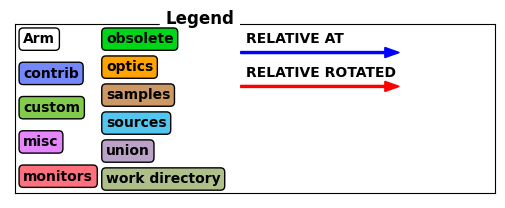

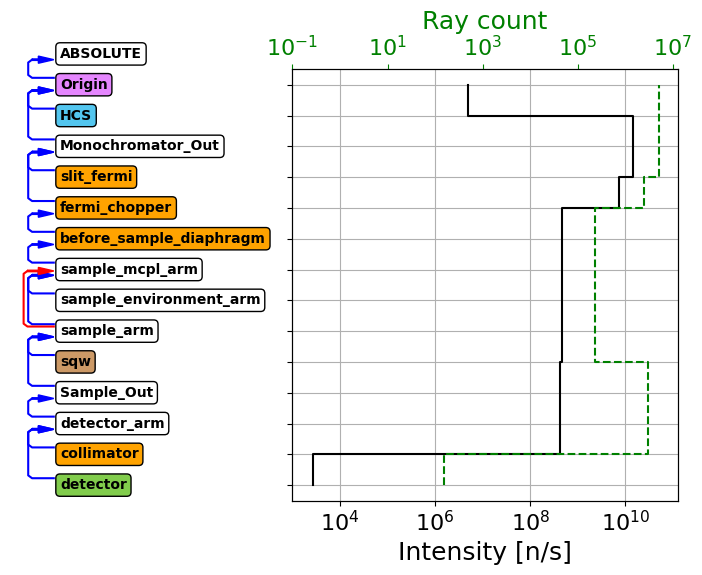

In [22]:
if flavour.find("quick")<0:
    for dch in [0]: #[0.05, 0.06, 0.04, 0]:
        print(dch)
        myinstrument.calculators["OriginCalc"].parameters["dch"]=dch
        mycalc.show_diagram(analysis=True, variable=None)
#else:
mycalc.show_diagram(analysis=True, variable=None)        

In [23]:
comp=mycalc.get_component("fermi_chopper")
#comp.zero_time=2
print(comp)
#mycalc.remove_component("detector")

COMPONENT fermi_chopper = FermiChopper(
  radius = 0.035468295701936395, // [m]
  nu = chopper_rpm/60, // [Hz]
  w = 0.0006, // [m]
  nslit = 45, // [1]
  R0 = 0, // [1]
  m = 0, // [1]
  length = 0.023, // [m]
  eff = 0.6880000000000001, // [1]
  zero_time = 2, // [1]
  verbose = 2, // [1]
  yheight = 0.113 // [m]
)
AT (0, 0, 1.7) RELATIVE Monochromator_Out


In [24]:
#mycalc.parameters["chopper_rpm"]=0
#mycalc.parameters["Ei"]=30 *ureg.meV
print(mycalc.parameters)

 - Parameters object -
mono_index                          -1                              Monochromator index. -1 = auto: based on the energy   (-1, 0, 1, 2, 3, 4)
a2                                  0          [degree]             Angle between beam reflected by monochromator and incident beam   L[36.0 degree, 58.97 degree](0 degree)
chopper_rpm                         0                               Fermi chopper speed   L[6000, 30000](0)
chopper_ratio                       1                                  (1, 2)
Ei                                  30         [millielectron_volt]  Initial neutron energy   L[7.5 millielectron_volt, 130 millielectron_volt]
dE                                  0.1        [millielectron_volt]  Initial neutron energy dispertion   
Efoc                                0          [millielectron_volt]  Focusing energy   
before_sample_slit_width            0.5        [meter]              Horizontal width of the slit opening   
before_sample_slit_height     

In [25]:
import mcstasscript as ms
diag = ms.Diagnostics(mycalc)
diag.settings(ncount=1e5, suppress_output=False)
diag.show_settings()
diag.clear_points()


for component in diag.instr.component_list:
        if component.component_name in ["Progress_bar", "Arm"]:
            continue
        if component.component_name in ["Beamstop"]:
            diag.add_point(before=component.name)
            continue
        if component.name in ["VCS", "HCS"]:
            diag.add_point(after=component.name)
            continue
        if component.component_name in ["Disk_Chopper", "Slit","Monochromator_curved","Fermi_chopper"]:
            diag.add_point(before=component.name)
            diag.add_point(after=component.name)
        else:
            #print("#"+component.name+"#")
            diag.add_point(before=component.name)
        



if mycalc.name == "SampleCalc":
    diag.clear_points()
    diag.add_point(after="Vin")
    diag.add_point(before="sqw")
    diag.add_point(after="Sample_Out")
    diag.add_point(before="after_sample_slit")
    diag.add_point(after="after_sample_slit")

#print(diag)


Instrument settings:
  ncount:           1.00e+05
  seed:             654321
  output_path:      /tmp/Panther/OriginCalc
  run_path:         ./
  package_path:     /usr/share/mcstas/3.3
  executable_path:  /usr/share/mcstas/3.3/bin/
  executable:       mcrun
  force_compile:    True


In [26]:
#mycalc.get_component("BC1").phase=41
#ch = mycalc.get_component("Chopper3")
#print(ch)
diag.settings(ncount=1e5)

In [27]:
diag.clear_points()
diag.add_point(before="fermi_chopper")
diag.add_point(after="fermi_chopper")
diag.add_point(before="before_sample_diaphragm")
diag.add_point(after="before_sample_diaphragm")
#diag.add_point(after="sample")
diag.add_point(before="collimator")
diag.add_point(after="collimator")
diag.add_point(before="detector")
diag.settings(ncount=1e5)


In [28]:
mycalc.parameters

 - Parameters object -
mono_index                          -1                              Monochromator index. -1 = auto: based on the energy   (-1, 0, 1, 2, 3, 4)
a2                                  0          [degree]             Angle between beam reflected by monochromator and incident beam   L[36.0 degree, 58.97 degree](0 degree)
chopper_rpm                         0                               Fermi chopper speed   L[6000, 30000](0)
chopper_ratio                       1                                  (1, 2)
Ei                                  30         [millielectron_volt]  Initial neutron energy   L[7.5 millielectron_volt, 130 millielectron_volt]
dE                                  0.1        [millielectron_volt]  Initial neutron energy dispertion   
Efoc                                0          [millielectron_volt]  Focusing energy   
before_sample_slit_width            0.5        [meter]              Horizontal width of the slit opening   
before_sample_slit_height     

In [29]:
diag.run()


loading system configuration
INFO: Using directory: "/tmp/Panther/OriginCalc_59"
INFO: Regenerating c-file: OriginCalc.c
CFLAGS=
      
 The parameter powder_format of sqw is initialized 
 using a static {,,,} vector.
  -> Such static vectors support literal numbers ONLY.
  -> Any vector use of variables or defines must happen via a 
     DECLARE/INITIALIZE pointer.


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 
-> SPLIT N at component sqw

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:
-> SPLIT within buffer at component sqw

-----------------------------------------------------------
INFO: Recompiling: ./OriginCalc.out
./OriginCalc.c: In function ‘init’:
./OriginCalc.c:16013:10: warning: format ‘%d’ expects argument of type ‘int’, but argument 2 has type ‘long int’ [-Wformat=]
16013 | printf("%d\n", mono_index);
      |         ~^
      |          |
      |  

In [30]:
diag.clear_views()
#diag.add_view("t")
#diag.add_view("x", bins=50, limits=[-0.04,0.04])
#diag.add_view("y", bins=50, same_scale=False, limits=[-0.07,0.07])
#diag.add_view("x","y",bins=[30,30])
#diag.add_view("e", same_scale=True)
#diag.add_view("l",same_scale=False)
#diag.add_view("t",same_scale=False)
#diag.add_view("t","x",same_scale=False, log=True)
#diag.add_view("t","y", same_scale=False)
#diag.add_view("x","y",same_scale=False, log=True)
#diag.add_view("dx","dy",same_scale=False,log=True) #, limits=[-50,-10],left_min=-45,right_lim=-20,bins=100)
#diag.add_view("dx","x",same_scale=False,log=True) #, limits=[-50,-10],left_min=-45,right_lim=-20,bins=100)
diag.add_view("dx","y",same_scale=False,log=True) #, limits=[-50,-10],left_min=-45,right_lim=-20,bins=100)

#diag.add_view("vz",same_scale=True)
print(diag)

Instrument diagnostics for: OriginCalc
Diagnostics points: 
  Diagnostics point before: fermi_chopper             - rays: 49668 / 50000
  Diagnostics point after:  fermi_chopper             - rays: 4477 / 50000
  Diagnostics point before: before_sample_diaphragm   - rays: 4477 / 50000
  Diagnostics point after:  before_sample_diaphragm   - rays: 4477 / 50000
  Diagnostics point before: collimator                - rays: 50000 / 50000
  Diagnostics point after:  collimator                - rays: 24501 / 50000
  Diagnostics point before: detector                  - rays: 50001 / 50000
Views: 
  View (dx, y)              bins: 100
Does contain simulated data


/users/nourbakhsh/digitaltwin/instrument_database/McStasScript/mcstasscript/data/data.py:811: RuntimeWarning: invalid value encountered in true_divide
  return np.arctan(vx/vz) * 180 / np.pi


ValueError: autodetected range of [nan, nan] is not finite

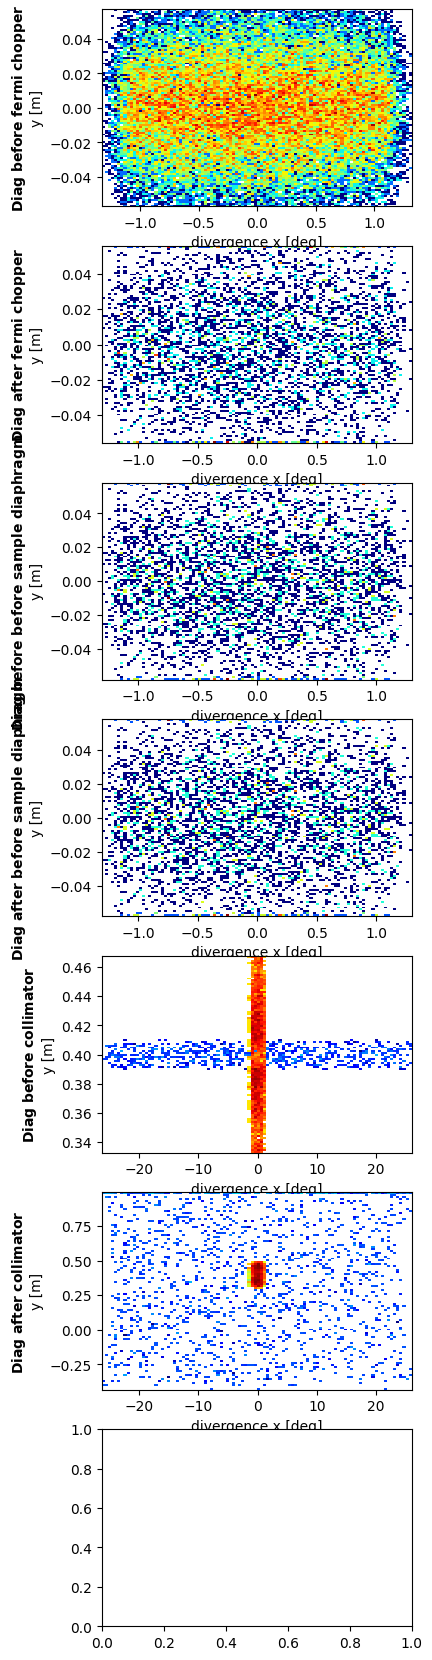

In [31]:
diag.plot()

In [ ]:
#myinstrument.show_instrument()

In [ ]:
"detpos" in myinstrument.master

In [ ]:
%matplotlib widget
import mcstasscript.jb_interface as ms_widget
#ms_widget.show(data_empty)

In [ ]:
#myinstrument.sample.set_SPLIT(60)
#myinstrument.sample

In [ ]:
#slit=myinstrument.calculators["SampleCalc"].get_component("after_sample_slit")
#slit.EXTEND=""
#slit.append_EXTEND("if(p<1e-1) ABSORB;")
#slit


In [ ]:
myinstrument.sim_neutrons(5e5)
#myinstrument.set_sample_by_name("H2O")
#myinstrument.master["bs_index"]=-1
myinstrument.run()

In [ ]:
data=myinstrument.output
#print(data)
calcname_data="DetectorCalc_data"
calcname_data="OriginCalc_data"
detectors=data[calcname_data].get_data()["data"]

In [ ]:
#print(data[calcname_data])

#print()
for detector in detectors:
    print(detector, "\n\t I = ",detector.Intensity, "\n\t E =", detector.Error, "\n\t N =", detector.Ncount)

In [ ]:
print(detectors)
#help(detector)
import mcstasscript as ms
ms.make_sub_plot(detectors[-3:], log=True)

In [ ]:
detector = detectors[3]
print(detector.Intensity)
import numpy as np
help(detector.Intensity)

In [ ]:
wmins=["1e-5", "1e-4", "1e-3", "1e-2", "1e-1"]
detectors=[]
for w_min in wmins:
    slit=myinstrument.calculators["SampleCalc"].get_component("after_sample_slit")
    slit.EXTEND=""
    slit.append_EXTEND(f"if(p<{w_min}) ABSORB;")
    myinstrument.run()
    data=myinstrument.output
    detector=(data["DetectorCalc_data"].get_data()["data"][0])
    detectors.append(detector)

In [ ]:
detectors

In [ ]:
import numpy as np

RHs = [0,1.75,2,2.25]#list() #np.arange(-1,4,1))
RVs = [0,1,2, 2.5,3] #list(np.arange(1,3,0.3))
#RVs.append(1.88)
#RHs.append(3.31)
print(RHs)
print(RVs)
diag_opt_component="before_sample_diaphragm"
diag_opt_component="fermi_chopper"
#mycalc.parameters["mono_rv"]=0
#mycalc.parameters["mono_rh"]=0

In [ ]:
#diag = ms.Diagnostics(mycalc)
#diag.settings(ncount=1e2, suppress_output=True,force_compile=True)
#diag.run()
diag.settings(ncount=1e5, suppress_output=True,force_compile=False)
diag.clear_points()
diag.add_point(before=diag_opt_component)
diag.add_point(after=diag_opt_component)
diag.clear_views()
diag.add_view("x","y",same_scale=True)
diag.add_view("dx","dy")
print(diag)

In [ ]:
help(diag)

In [ ]:
diag.set_parameters(mono_rh=RHs[0])

for RV in RVs:
    print(RV)
    diag.instr.parameters["mono_rv"]=RV
    diag.set_parameters(mono_rv=RV)
    diag.run()
    diag.plot()
#(RHmono,RVmono) = (3.31,1.88)
#lambda: 4.05
#lambda: 4.05 +/- 0.04
#energy: 4.98 +/- 0.10
#(RHanalyzer,RVanalyzer) = (4.17,0.77)
#'Monochromator', 'counter', 'before_sample_slit', 'sqw', 'after_sample_slit', 'analyzer', 'slit', 'detector_all']

In [ ]:
diag.set_parameters(mono_rv=RVs[0])

for RH in RHs:
    print(RH)
    diag.set_parameters(mono_rh=RH)
    diag.run()
    print(diag)
    diag.plot()


In [ ]:
print(diag)

In [ ]:
diags= [] 

print(RHs)
for RH in RHs:
    print(RH)
    mycalc.parameters["mono_rh"]=RH
    diag = ms.Diagnostics(mycalc)
    diag.settings(ncount=1e5, suppress_output=True,force_compile=False)
    diag.clear_points()
    diag.add_point(after=diag_opt_component)
#    diag.add_point(before="sqw")
    diag.run()
    diags.append(diag)

In [ ]:
print(diag)

In [ ]:
for diag in diags:
    diag.clear_views()
    #diag.add_view("x", bins=50, limits=[-0.04,0.04])
    #diag.add_view("y", bins=50, same_scale=False, limits=[-0.07,0.07])
    diag.add_view("x","y")
    diag.add_view("dx","dy")
    #diag.add_view("dx")
    #diag.add_view("dy")
    diag.plot()
    print(diag)

In [ ]:
for diag in diags:
    diag.clear_views()
    diag.add_view("x", bins=50, limits=[-0.04,0.04])
    diag.add_view("y", bins=50, same_scale=False, limits=[-0.07,0.07])
    #diag.add_view("x","y",bins=[30,30])
    #diag.add_view("dx","dy")
    diag.add_view("dx")
    diag.add_view("dy")
    diag.plot()

In [ ]:
myinstrument.force_compile(False)
myinstrument.sim_neutrons(1e5)
counter=[]
detector=[]
mycalc = myinstrument.calculators["OriginCalc"]
for RV in RVs:
    for RH in RHs:
        mycalc.parameters["RHmono"].value = RH
        mycalc.parameters["RVmono"].value = RV
        #print(mycalc.parameters)
        myinstrument.run()
        counter.append(myinstrument.output["OriginCalc_data"].get_data()["data"])

In [ ]:
i=0
i_det=1
for RV in RVs:
    for RH in RHs:
        c = counter[i]
        det=c[1]
        print(i, "\t" , RV, RH, "\t\t" , det.Intensity, det.Error, det.Ncount)
        i=i+1

In [ ]:
mycalc.output

In [ ]:
print(myinstrument.output)

In [ ]:
RHs = list(np.arange(1.5,3,0.2))
RVs = list(np.arange(0.3,1.2,0.2))
RVs.append(0.51)
RHs.append(1.41)
print(RHs)
print(RVs)

myinstrument.force_compile(False)
myinstrument.sim_neutrons(1e5)
counter=[]

mycalc = myinstrument.calculators["OriginCalc"]
for RV in RVs:
    for RH in RHs:
        mycalc.parameters["RHanalyzer"].value = RH
        mycalc.parameters["RVanalyzer"].value = RV
        #print(mycalc.parameters)
        myinstrument.run()
        counter.append(myinstrument.output["OriginCalc_data"].get_data()["data"])

In [ ]:
i=0
i_det=1
intensities = []
counts = []
for RV in RVs:
    for RH in RHs:
        c = counter[i]
        det=c[1]
        #print(i, "\t" , RV, RH, "\t\t" , det.Intensity, det.Error, det.Ncount)
        intensities.append(det.Intensity)
        counts.append(det.Ncount)
        i=i+1

In [ ]:
max(intensities)

In [ ]:
max(counts)

In [ ]:
intensities.index(max(intensities))

In [ ]:
counts.index(max(counts))

In [ ]:
i=0
for RV in RVs:
    for RH in RHs:
        print(RV, RH, counts[i])
        if i==counts.index(max(counts)):
            print("---> ",RV, RH)
        i=i+1

In [ ]:
RVs

In [ ]:
RHs

In [ ]:
dist_sample_ana = 1.260
dist_ana_det = 0.640
import math
ana_focus = 1.0 / (1.0 / dist_sample_ana + 1.0 / dist_ana_det)

In [ ]:

def rh(ana_focus):
    return 2*ana_focus/math.sin(math.pi/180*myinstrument.master["a6"].value/2)
def rv(ana_focus):
    return 2*ana_focus*math.sin(math.pi/180*myinstrument.master["a6"].value/2)


In [ ]:
print(rv(ana_focus),rh(ana_focus))

In [ ]:
ana_focus=dist_ana_det
print(rv(ana_focus),rh(ana_focus))

In [ ]:
flavour.find("quicka")

In [ ]:
import mcstasscript as ms
import math
instrument = ms.McStas_instr("test")

source = instrument.add_component("source", "Source_simple")
source.set_parameters(xwidth=0.05, yheight=0.03, dlambda=0.02,
                      dist=1.7, focus_xw=0.3, focus_yh=0.05)
#source.lambda0 = instrument.add_parameter("wavelength", value=2.0)
source.E0=6

slit = instrument.add_component("slit","Slit", AT=1.60, RELATIVE=source)

#fermi=instrument.add_component("fermi","Arm", AT=5, RELATIVE=source)
fermi = instrument.add_component("fermi", "FermiChopper", AT=1.700, RELATIVE=source)
        # L_bc5_fermi = L_bc5_fermi + fermi.AT_data[2]
        # print(L_bc5_fermi)

fermi.set_parameters(
            radius=math.sqrt((0.0006 * 45) ** 2 + 0.023 ** 2),
            nslit=45,
            length=0.023,
            w=0.0006,
            yheight=0.113,
            nu=500,
            verbose=2,
            eff=0.86 * 0.8,
            m=0,
            R0=0,  # no super mirror
            zero_time=2,
            # delay=0.007,
            # delay=str(L_bc5_fermi) + " / neutron_velocity",
            #            delay=0.0065,
            # phase=-23.1209 * 2,
        )
print(fermi.radius)
slit.xwidth=fermi.radius*2*0.9
slit.yheight=fermi.yheight
class sample:
    """"""
    radius=0.1
    yheight=0.1
    
mon = instrument.add_component("PSD", "PSD_monitor")
mon.set_AT(0.1, RELATIVE=fermi)
mon.set_parameters(nx=100, ny=100, filename='"psd.dat"',
                   xwidth=5*sample.radius, yheight=2*sample.yheight, restore_neutron=1)


In [ ]:
diag = ms.Diagnostics(instrument)
diag.settings(ncount=1e5, suppress_output=False)
diag.show_settings()
diag.clear_points()
#diag.add_point(before="slit")
#diag.add_point(after="slit")

diag.add_point(after="fermi")

diag.run()


In [ ]:
diag.clear_views()
diag.add_view("x","y",same_scale=True, log=True)
diag.add_view("t","x",same_scale=False, log=True)
diag.plot()

In [ ]:
instrument.show_diagram(analysis=True, variable=None)